In [2]:
import sys
sys.path.insert(0, '/tf/utils/')

In [14]:
from tensorflow.keras.models import load_model
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import Audio

import librosa
from datetime import datetime
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from pesq import pesq
import pystoi
import pandas as pd

from utils import calculate_snr, itakura_distortion, somar_sinais, add_white_gaussian_noise, performance

from sound import Sound
import tensorflow.keras.backend as K
import librosa

In [4]:
base_shape_size = 8192
ws = 255
ol = 128

In [6]:
sound_base = Sound('../Dados/Base/', '../Dados/ESC-50-master/audio/', base_shape_size)

Loading noise files: 100%|██████████| 2000/2000 [00:09<00:00, 215.13it/s]


In [7]:
class DataGenerator:
    def __init__(self, sound_files, noise_files):
        self.sound_files = sound_files
        self.noise_files = noise_files

    def generate_sample_completo(self, batch_size=32):
        while True:
            # Carrega um lote de sons
            sound_batch_choices = np.random.choice(self.sound_files.shape[0], size=batch_size, replace=False)
            sound_batch = self.sound_files[sound_batch_choices]
            
            # Carrega um lote de ruídos
            noise_batch_choices = np.random.choice(self.noise_files.shape[0], size=batch_size, replace=False)
            noise_batch = self.noise_files[noise_batch_choices]
            
            x_train = []
            x_snr_train = []
            y_train = []
            
            # Adiciona ruído a cada som e calcula a nota PESQ
            for sound, noise in zip(sound_batch, noise_batch):
                # noisy_sound = somar_sinais(sound, noise, sr)
                min_valor = np.min(sound)
                max_valor = np.max(sound)
                
                # Defina o novo intervalo desejado
                novo_min = -0.4
                novo_max = 0.4
                
                # Realize a escala do sinal para o novo intervalo
                sound_escalado = (sound - min_valor) / (max_valor - min_valor) * (novo_max - novo_min) + novo_min

                sr = np.random.randint(0, 20, size=(1,)[0])
                noisy_sound = somar_sinais(sound_escalado, noise, sr)
                
                # noisy_sound = add_white_gaussian_noise(noisy_sound, np.random.randint(20, 30, size=(1,)[0]))
                noisy_sound = add_white_gaussian_noise(noisy_sound, np.random.randint(20, 30, size=(1,)[0]))
                noisy_sound = np.clip(noisy_sound, -1.0, 1.0)
                
                A, phi, _, _ = calculate_stft_magnitude_and_phase(sound_escalado)
                A_noisy, phi_noisy, _, _ = calculate_stft_magnitude_and_phase(noisy_sound)

                
                # # 1. Calcule a magnitude do ruído em cada frame
                # Mag_ruido = np.abs(A - A_noisy)

                # # 2. Calcule a SNR para cada frame
                # P_sinal = np.sum(A**2, axis=0)
                # P_ruido = np.sum(Mag_ruido**2, axis=0)
                # SNR = 10 * np.log10(P_sinal / P_ruido)
                # SNR = SNR.reshape(1, SNR.shape[0], 1)

                # Monta o fasor normalizando a faze por Pi
                F = np.concatenate([A.reshape(A.shape[0], A.shape[1], 1), (phi.reshape(phi.shape[0], phi.shape[1], 1) / (2*np.pi)) + 0.5], axis=-1)
                F_noisy = np.concatenate([A_noisy.reshape(A_noisy.shape[0], A_noisy.shape[1], 1), (phi_noisy.reshape(phi_noisy.shape[0], phi_noisy.shape[1], 1) / (2*np.pi)) + 0.5], axis=-1)
                
                # Adiciona o exemplo ao lote de treinamento
                x_train.append(F_noisy)
                y_train.append(F)
                # x_snr_train.append(SNR)
                

            x_train = np.array(x_train)
            y_train = np.array(y_train)
            # x_snr_train = np.array(x_snr_train)

            # yield (x_train, x_snr_train), y_train
            yield x_train, y_train

In [13]:
sound_base.clean_sounds[0].shape

(8192,)

In [47]:
# Função para calcular a energia de um segmento de áudio
def calculate_energy(frame):
    return np.sum(np.square(frame))

# Função para calcular a frequência média de um segmento de áudio
def calculate_frequency(frame, sample_rate):
    fft_result = np.fft.fft(frame)
    fft_result = np.abs(fft_result[:len(frame) // 2])  # Apenas a metade positiva do espectro
    bin_freqs = np.fft.fftfreq(len(frame), 1 / sample_rate)[:len(frame) // 2]
    
    weighted_sum = np.sum(fft_result * bin_freqs)
    total_energy = np.sum(fft_result)
    
    if total_energy == 0:
        return 0
    
    return weighted_sum / total_energy

# Função para determinar se um segmento de áudio contém voz
def is_voice(frame, sample_rate, energy_threshold, frequency_threshold):
    frame_energy = calculate_energy(frame)
    frame_frequency = calculate_frequency(frame, sample_rate)
    
    if frame_energy > energy_threshold and frame_frequency > frequency_threshold:
        return True
    else:
        return False

# Função para aplicar o VAD ao sinal de áudio completo
def apply_vad(audio_signal, sample_rate=8000, window_size=320, overlap=160, energy_threshold=5000, frequency_threshold=1000):
    vad_mask = []  # Lista para armazenar a máscara VAD
    
    for i in range(0, len(audio_signal), window_size - overlap):
        frame = audio_signal[i:i+window_size]
        if len(frame) < window_size:
            break
        if is_voice(frame, sample_rate, energy_threshold, frequency_threshold):
            vad_mask.append(True)
        else:
            vad_mask.append(False)
    
    return vad_mask

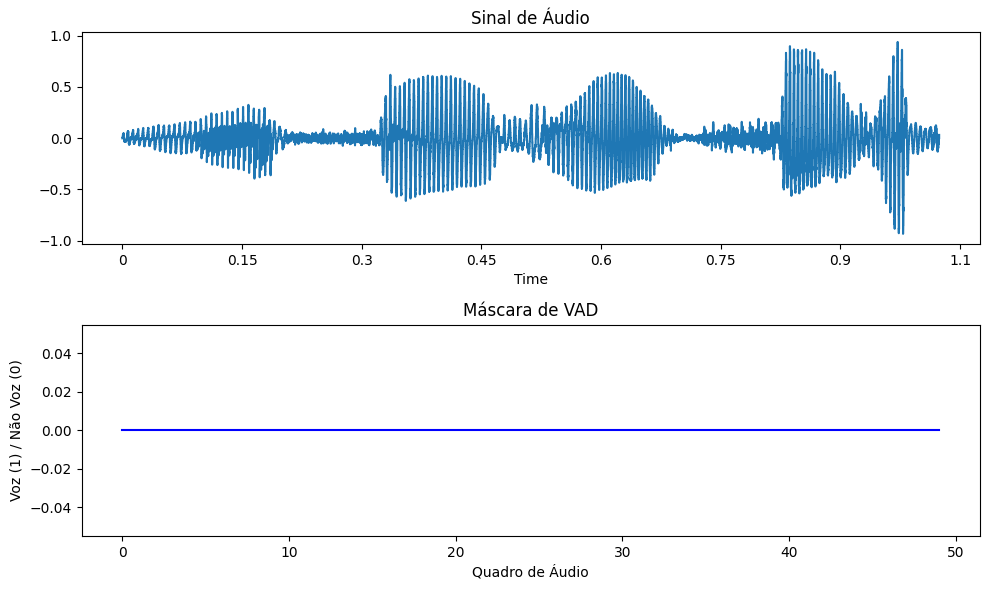

In [48]:
signal = sound_base.clean_sounds[1]

vad_result = apply_vad(signal)

# Plot do sinal de áudio
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
librosa.display.waveshow(signal, sr=8000)
plt.title("Sinal de Áudio")

# Plot da máscara de VAD
plt.subplot(2, 1, 2)
plt.plot(vad_result, color='b')
plt.title("Máscara de VAD")
plt.xlabel("Quadro de Áudio")
plt.ylabel("Voz (1) / Não Voz (0)")

plt.tight_layout()
plt.show()

In [49]:
Audio(data=signal, rate=8000)